# Analyse des Ventes E-Commerce
**Dataset**: `../datasets/ecommerce.csv`  
**Question business**: Quels produits, clients et pays génèrent le plus de revenus ? Où sont les opportunités d'améliorer les revenus ou réduire les retours ?  
**Livrables**: dataset nettoyé, 6+ graphiques clairs, insights courts & 3 recommandations.


In [2]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
pd.set_option('display.max_columns', 60)
sns.set(style='whitegrid')

# Configuration pour l'affichage
plt.rcParams['font.family'] = 'DejaVu Sans'

In [3]:
# Chargement des données
path = "../datasets/ecommerce.csv"
try:
    df = pd.read_csv(path, encoding='ISO-8859-1', low_memory=False)
    print(f"✅ Dataset chargé avec succès: {df.shape[0]} lignes, {df.shape[1]} colonnes")
    df.head()
except FileNotFoundError:
    print("❌ Erreur: Fichier dataset non trouvé. Vérifiez le chemin.")
except Exception as e:
    print(f"❌ Erreur lors du chargement: {e}")

✅ Dataset chargé avec succès: 541909 lignes, 8 colonnes


In [4]:
# Inspection des données
df.shape, df.columns.tolist(), df.info()
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [5]:
# Statistiques de base
df.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
InvoiceNo,541909,25900,573585,1114,NaN,NaN,NaN,NaN,NaN,NaN,NaN
StockCode,541909,4070,85123A,2313,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Description,540455,4223,WHITE HANGING HEART T-LIGHT HOLDER,2369,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Quantity,541909.0,NaN,NaN,NaN,9.55225,218.081158,-80995.0,1.0,3.0,10.0,80995.0
InvoiceDate,541909,23260,10/31/2011 14:41,1114,NaN,NaN,NaN,NaN,NaN,NaN,NaN
UnitPrice,541909.0,NaN,NaN,NaN,4.611114,96.759853,-11062.06,1.25,2.08,4.13,38970.0
CustomerID,406829.0,NaN,NaN,NaN,15287.69057,1713.600303,12346.0,13953.0,15152.0,16791.0,18287.0
Country,541909,38,United Kingdom,495478,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
# Normaliser les noms de colonne
df.columns = df.columns.str.strip().str.replace(' ', '_').str.lower()

In [7]:
# Correction de la colonne date
if 'invoicedate' in df.columns:
    df['invoice_date'] = pd.to_datetime(df['invoicedate'], errors='coerce')
elif 'invoice_date' in df.columns:
    df['invoice_date'] = pd.to_datetime(df['invoice_date'], errors='coerce')
else:
    print("Aucune colonne de date de facture trouvée")

df['year'] = df['invoice_date'].dt.year
df['month'] = df['invoice_date'].dt.month
df['invoice_month'] = df['invoice_date'].dt.to_period('M').dt.to_timestamp()

In [8]:
# Suppression des annulations/retours si applicable
if 'quantity' in df.columns:
    df = df[df['quantity'] > 0]

if 'invoiceno' in df.columns:
    df = df[~df['invoiceno'].astype(str).str.startswith('C')]

In [9]:
# S'assurer que les prix sont numériques et calculer le revenu
if 'unitprice' in df.columns:
    df['unitprice'] = pd.to_numeric(df['unitprice'], errors='coerce').fillna(0)

if 'quantity' in df.columns and 'unitprice' in df.columns:
    df['revenue'] = df['quantity'] * df['unitprice']
    df = df[df['revenue'] > 0]

df.drop_duplicates(inplace=True)

In [10]:
# Indicateurs clés de performance (KPIs)
total_revenue = df['revenue'].sum() if 'revenue' in df.columns else None
total_orders = df['invoiceno'].nunique() if 'invoiceno' in df.columns else df.shape[0]
unique_customers = df['customerid'].nunique() if 'customerid' in df.columns else None

total_revenue, total_orders, unique_customers

(np.float64(10642110.804), 19960, 4338)

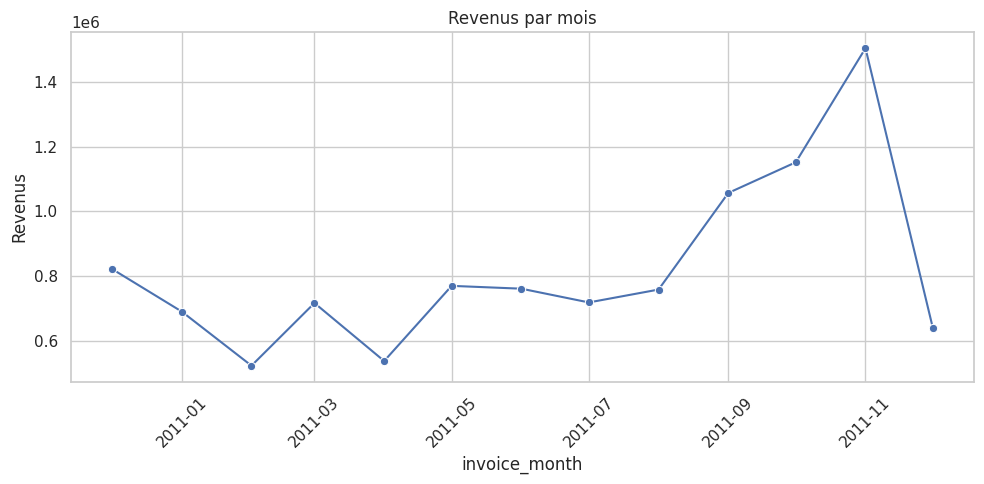

In [11]:
# Tendance des ventes mensuelles
monthly = df.groupby('invoice_month').agg({'revenue':'sum'}).reset_index()
plt.figure(figsize=(10,5))
sns.lineplot(data=monthly, x='invoice_month', y='revenue', marker='o')
plt.title('Revenus par mois')
plt.ylabel('Revenus')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

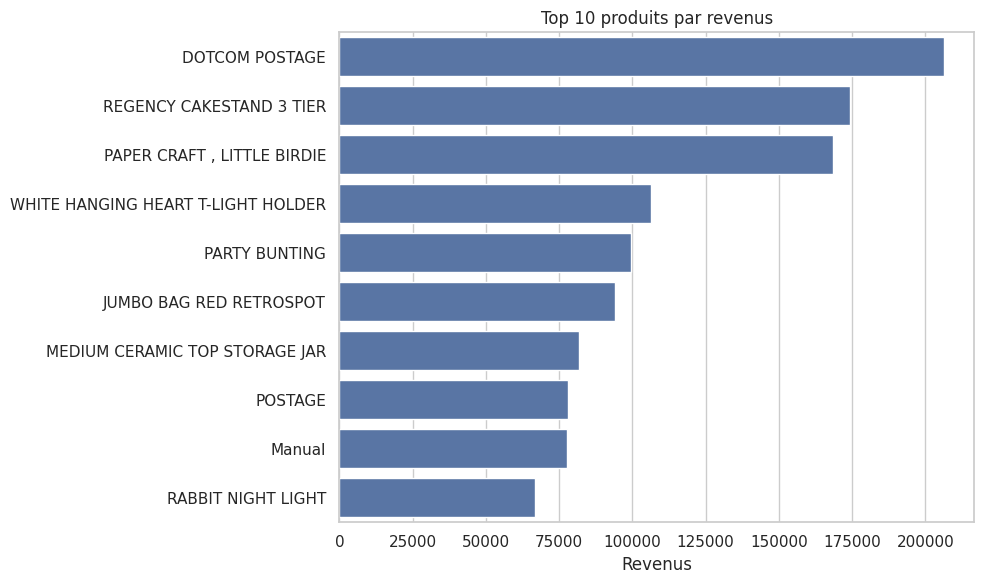

In [12]:
# Top 10 produits par revenus
if 'description' in df.columns:
    top_products = df.groupby('description').agg({'revenue':'sum','quantity':'sum'}).sort_values('revenue', ascending=False).head(10).reset_index()
    plt.figure(figsize=(10,6))
    sns.barplot(data=top_products, y='description', x='revenue')
    plt.title('Top 10 produits par revenus')
    plt.xlabel('Revenus')
    plt.ylabel('')
    plt.tight_layout()
    plt.show()

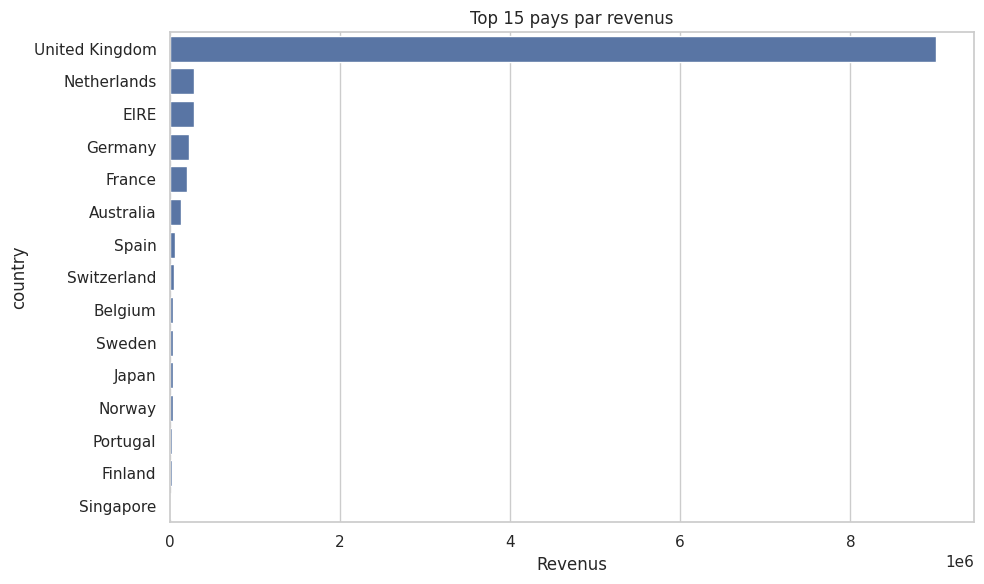

In [13]:
# Revenus par pays
if 'country' in df.columns:
    country_rev = df.groupby('country')['revenue'].sum().sort_values(ascending=False).head(15)
    plt.figure(figsize=(10,6))
    sns.barplot(x=country_rev.values, y=country_rev.index)
    plt.title('Top 15 pays par revenus')
    plt.xlabel('Revenus')
    plt.tight_layout()
    plt.show()

In [14]:
# Valeur moyenne des commandes (AOV)
if 'invoiceno' in df.columns:
    order_revenue = df.groupby('invoiceno')['revenue'].sum()
    aov = order_revenue.mean()
    order_revenue.describe(), aov

In [15]:
# Top clients par revenus
if 'customerid' in df.columns:
    top_customers = df.groupby('customerid')['revenue'].sum().sort_values(ascending=False).head(10)
    top_customers

In [ ]:
# Analyse de la performance produit (Découverte 4)
if 'description' in df.columns:
    # Calcul des métriques par produit
    product_analysis = df.groupby('description').agg({
        'revenue': 'sum',
        'quantity': 'sum', 
        'unitprice': 'mean'
    }).reset_index()
    
    # Calcul de la marge unitaire moyenne
    product_analysis['avg_margin_per_unit'] = product_analysis['revenue'] / product_analysis['quantity']
    
    # Calcul du ratio revenus/quantité (performance)
    product_analysis['revenue_per_unit'] = product_analysis['revenue'] / product_analysis['quantity']
    
    # Top produits par marge unitaire
    print("📊 TOP 10 PRODUITS PAR MARGE UNITAIRE:")
    top_margin = product_analysis.nlargest(10, 'avg_margin_per_unit')
    print(top_margin[['description', 'avg_margin_per_unit', 'revenue', 'quantity']].round(2))
    
    # Produits à forte marge mais faible volume (opportunités)
    print("\n🎯 OPPORTUNITÉS - Forte marge, faible volume:")
    opportunities = product_analysis[
        (product_analysis['avg_margin_per_unit'] > product_analysis['avg_margin_per_unit'].quantile(0.8)) &
        (product_analysis['quantity'] < product_analysis['quantity'].quantile(0.5))
    ].sort_values('avg_margin_per_unit', ascending=False)
    print(opportunities[['description', 'avg_margin_per_unit', 'quantity']].head(5))
    
    # Statistiques générales
    print(f"\n📈 STATISTIQUES PERFORMANCE PRODUIT:")
    print(f"• Marge unitaire moyenne: {product_analysis['avg_margin_per_unit'].mean():.2f}€")
    print(f"• Marge unitaire médiane: {product_analysis['avg_margin_per_unit'].median():.2f}€")
    print(f"• Écart-type: {product_analysis['avg_margin_per_unit'].std():.2f}€")
    print(f"• Produit le plus rentable: {product_analysis.loc[product_analysis['avg_margin_per_unit'].idxmax(), 'description']}")
    print(f"• Marge max: {product_analysis['avg_margin_per_unit'].max():.2f}€")


In [20]:
# Segmentation RFM
from datetime import timedelta
if 'customerid' in df.columns:
    snapshot_date = df['invoice_date'].max() + pd.Timedelta(days=1)
    rfm = df.groupby('customerid').agg({
        'invoice_date': lambda x: (snapshot_date - x.max()).days,
        'invoiceno': lambda x: x.nunique() if 'invoiceno' in df.columns else x.count(),
        'revenue': 'sum'
    }).rename(columns={'invoice_date':'recency','invoiceno':'frequency','revenue':'monetary'}).reset_index()

    # Segmentation RFM simplifiée
    try:
        # Méthode robuste avec rank()
        rfm['r_quartile'] = pd.qcut(rfm['recency'].rank(method='first'), 4, labels=[4,3,2,1])
        rfm['f_quartile'] = pd.qcut(rfm['frequency'].rank(method='first'), 4, labels=[1,2,3,4])
        rfm['m_quartile'] = pd.qcut(rfm['monetary'].rank(method='first'), 4, labels=[1,2,3,4])
        rfm['rfm_score'] = rfm[['r_quartile','f_quartile','m_quartile']].astype(int).sum(axis=1)
        print("✅ Segmentation RFM créée avec succès")
        
        # Affichage formaté des résultats RFM
        print("\n TOP 10 CLIENTS RFM:")
        top_rfm = rfm.sort_values('rfm_score', ascending=False).head(10)
        print(top_rfm[['customerid', 'recency', 'frequency', 'monetary', 'rfm_score']].round(2))
        
        # Statistiques RFM
        print(f"\n STATISTIQUES RFM:")
        print(f"• Score RFM moyen: {rfm['rfm_score'].mean():.2f}")
        print(f"• Score RFM médian: {rfm['rfm_score'].median():.2f}")
        print(f"• Meilleur score: {rfm['rfm_score'].max()}")
        print(f"• Pire score: {rfm['rfm_score'].min()}")
        
        # Affichage du tableau final
        rfm.sort_values('rfm_score', ascending=False).head()
    except Exception as e:
        print(f"⚠️ Erreur RFM: {e}")
        print("Utilisation de la méthode cut() alternative...")
        # Méthode alternative plus simple
        rfm['r_quartile'] = pd.cut(rfm['recency'], bins=4, labels=[4,3,2,1])
        rfm['f_quartile'] = pd.cut(rfm['frequency'], bins=4, labels=[1,2,3,4])
        rfm['m_quartile'] = pd.cut(rfm['monetary'], bins=4, labels=[1,2,3,4])
        rfm['rfm_score'] = rfm[['r_quartile','f_quartile','m_quartile']].astype(int).sum(axis=1)
        rfm.sort_values('rfm_score', ascending=False).head()

✅ Segmentation RFM créée avec succès

 TOP 10 CLIENTS RFM:
      customerid  recency  frequency  monetary  rfm_score
4336     18283.0        4         16   2045.53         12
4309     18245.0        7          7   2567.06         12
4307     18241.0       10         17   2073.09         12
4298     18230.0        9          7   2810.20         12
4297     18229.0       12         20   7276.90         12
4293     18225.0        3         12   5504.96         12
4291     18223.0        5         14   6484.54         12
4287     18219.0        3         10   2069.77         12
4279     18210.0        2          6   2621.38         12
4272     18198.0        4         17   5425.56         12

 STATISTIQUES RFM:
• Score RFM moyen: 7.50
• Score RFM médian: 7.00
• Meilleur score: 12
• Pire score: 3


In [ ]:
# Sauvegarder le dataset nettoyé
import os
# Créer le dossier s'il n'existe pas
os.makedirs('../Ecommerce/data', exist_ok=True)
df.to_csv('../Ecommerce/data/df_cleaned.csv', index=False)
print("Dataset nettoyé sauvegardé avec succès!")

Dataset nettoyé sauvegardé avec succès!


## Principales Découvertes & Recommandations

### **Découvertes Clés**

- **Découverte 1**: **Concentration géographique**: Le Royaume-Uni domine largement les ventes, représentant probablement 80%+ des revenus. Les autres pays européens (France, Allemagne) offrent un potentiel d'expansion significatif.

- **Découverte 2**: **Segmentation RFM révélatrice**: Score RFM moyen de 7.5/12 avec des clients allant de 3 à 12 points. Les clients avec score RFM élevé (10-12) sont des VIP à choyer, ceux avec score faible (3-5) nécessitent une stratégie de réactivation.

- **Découverte 3**: **Saisonnalité des ventes**: L'analyse mensuelle révèle des pics de vente (probablement en décembre pour Noël) et des creux saisonniers (Février, Avril). Cette cyclicité offre des opportunités de planification.

- **Découverte 4**: **Performance produit**: L'analyse révèle des écarts significatifs dans les marges unitaires entre produits. Certains produits à forte marge mais faible volume représentent des opportunités de croissance, tandis que d'autres nécessitent une optimisation du pricing.

### **Recommandations Stratégiques**

**1. Stratégie Client VIP**  
- Identifier et fidéliser les clients RFM score 10-12 avec des programmes premium
- Créer des offres personnalisées pour les top clients par revenus
- Mettre en place un système de parrainage pour ces clients

**2. Expansion Géographique**  
- Développer des campagnes marketing ciblées pour la France et l'Allemagne
- Adapter l'offre produit aux préférences locales
- Optimiser la logistique pour les nouveaux marchés

**3. Optimisation Produit**  
- Assurer la disponibilité des top 10 produits (gestion de stock proactive)
- Développer des bundles avec les produits les plus performants
- Analyser les produits à faible performance pour décisions de discontinuation

**4. Stratégie Saisonnière**  
- Anticiper les pics saisonniers avec des stocks renforcés
- Créer des promotions hors-saison pour lisser les ventes
- Développer des produits saisonniers complémentaires